#### name    : MANISH KUMAR
#### roll    : 200102108
#### e-mail  : manish200104057@iitg.ac.in

In [ ]:
# LINK:

In [ ]:
# https://colab.research.google.com/drive/1ucGbhLwFc084E6TJ4paSGMyBs3k2nL1g?usp=sharing

In [ ]:
#  FOR LATEX FILES (OVERLEAF LINK)

In [ ]:
# https://www.overleaf.com/read/ppwjsmpqkrwz#3f03a4

## Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [8, 8]
import math
import numpy as np
import random
from PIL import Image
import time

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Generation

### Define the non-linear system

In [ ]:
## choosing an arbitrary NON-LINEAR function
## Choosing a 2D dynamic system (easir to visualize)
## basically : inp -> time-step(t)
##             out -> x-y coordinates (x_t, y_t)

def non_linear_sys(x0, y0, dt=0.01):
  '''
  params: x and y coordinate at some time (t)
  return: x and y coordinates at time instant (t+1)
  '''

  dx = 2*np.sin(x0) + y0 - 3.5
  dy = x0 - 3.5*np.cos(y0) + 2.9

  x1 = x0 + dx*dt
  y1 = y0 + dy*dt
  return x1, y1


def generate_path(x0, y0, steps=100, dt=0.01):
  '''
  params: initial x and y coordinates to start with, number of points in path
  return: List[(x,y)] -- i.e the trajectory evolved over time following the dynamics of system
  '''
  path = []
  xt, yt = x0, y0
  for _ in range(steps):
    path.append((xt, yt))
    xt, yt = non_linear_sys(xt, yt, dt) ## increment
  return path


def visualize_path(x0, y0, steps=100, dt=0.01):
  '''
  draws the trajectory give starting point
  '''
  trajectory = generate_path(x0, y0, steps, dt)
  x_coor , y_coor = zip(*trajectory)
  plt.plot(x_coor, y_coor,'o', '--')
  plt.grid()
  plt.show()

def flow_field():
  for _ in range(500):
    x0, y0 = np.random.rand(2)*4 - 2
    traj = generate_path(x0, y0,150)
    x_coor , y_coor = zip(*traj)
    plt.plot(x_coor, y_coor, '--')
    plt.grid()
  plt.grid()
  plt.show()

### some visualisations

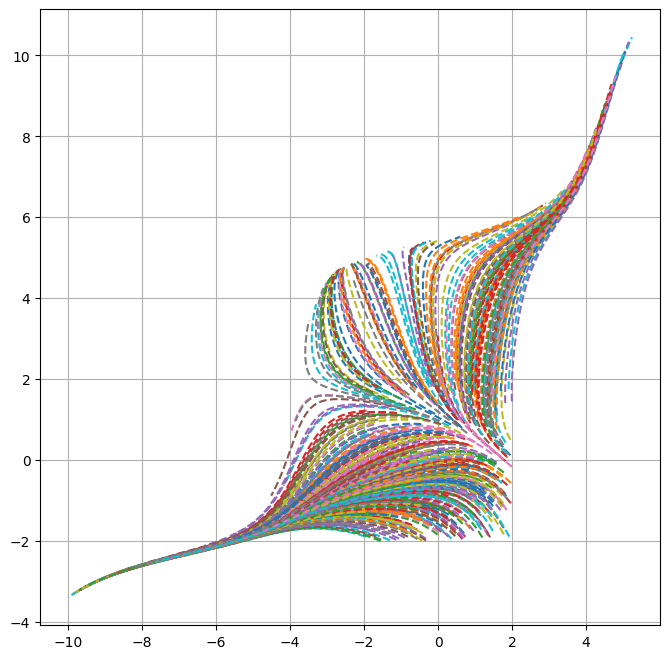

In [ ]:
flow_field()

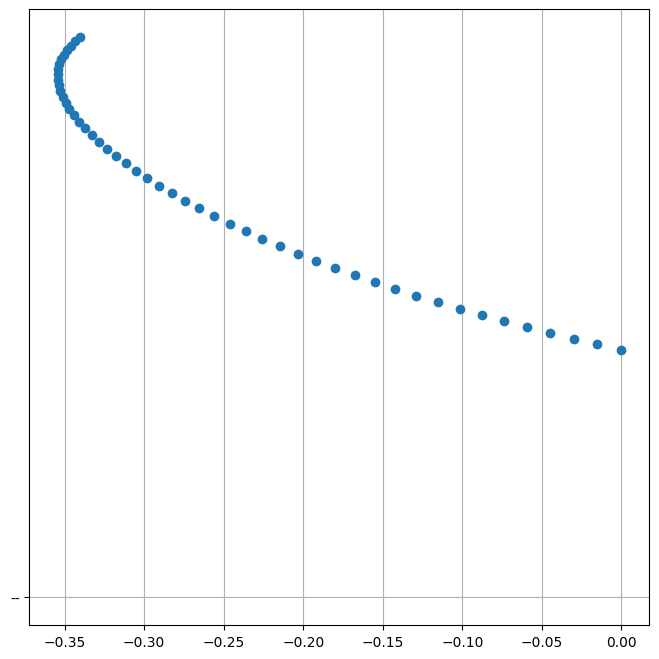

In [ ]:
N = 50
visualize_path(0,2, N)

In [ ]:
# generate_path(0, 0,50)

## Dataloaders and Hyperparams




### Hyper params

In [ ]:
hyper_param = {
    'n_epoch': 150,
    'batch_size':1024,
    'input_dim':32,
    'latent_dim':128,
    'learning_rate': 0.001,
    'prev_k':16
}
N_PATHS = 1500
T_STEPS = 150

In [ ]:
## data generator

def generate_data(n_path, time_steps):
  '''
  return List of x,y coordinates simulated over 'n_path' paths taking random starting point
  '''
  ds = []
  for _ in range(n_path):
    x0, y0 = np.random.rand(2)*4 - 2
    ds.append(generate_path(x0, y0, steps=time_steps, dt=0.01))
  return ds

In [ ]:
# generate_data(5, 10)

### Dataset

In [ ]:
class koopman_ds(Dataset):
  def __init__(self, dataset, k):
    ## take prev k samples
    ## input -> x_t-10, x_t-9, x_t-8, ... , x_t-1, x_t
    ## output ->         x_t-9, x_t-8, ..., x_t-1, x_t, x_t+1
    ### note x is (x_corr, y_corr)
    self.k = k
    self.trajectories = dataset
    self.n_paths = len(dataset)
    self.path_len = len(dataset[0])
    self.len_ds = self.n_paths*(self.path_len - 1)
    self.padding = (0,0)

  def __len__(self):
    return self.len_ds

  def get_prev_k(self, path_idx, time_idx, k):
    assert path_idx < self.n_paths, f'expected < {self.n_paths} got {path_idx}'
    assert time_idx < self.path_len, f'expected < {self.path_len} got {time_idx}'
    path = self.trajectories[path_idx]
    end = time_idx
    start = max(0, time_idx - k+1)
    pad_len = k - (end - start + 1)
    # print(k,path_idx, time_idx, start, end, pad_len)
    res = [self.padding]*pad_len + path[start : end + 1]
    assert len(res) == k, f'{len(res)}'
    return res ## [(x,y), ...]

  def __getitem__(self, idx):
    ## return 2 list (x and y coordinates of prev k points) of torch.tensors
    ### decode idx to path_idx and time_idx
    path_idx = idx // (self.path_len - 1)
    time_idx = idx % (self.path_len - 1)
    ## return k+1 points
    ## ..., p_k-1, p_k , p_k+1 --- like this
    data = self.get_prev_k(path_idx, time_idx+1, self.k+1)
    x, y = zip(*data)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

data = generate_data(n_path = N_PATHS, time_steps=T_STEPS)
dataset = koopman_ds(data , hyper_param['prev_k'])

In [ ]:
# torch.tensor?

In [ ]:
len(dataset)

223500

In [ ]:
for _ in range(10000):
  idx = np.random.randint(len(dataset))
  x, y = dataset[idx]
  assert len(x) == len(y) == 17

In [ ]:
dataset[1490]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1746, 1.1656]),
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7504, 0.7655]))

### DataLoader

In [ ]:
train_dl = DataLoader(dataset, batch_size=hyper_param['batch_size'], num_workers=2, shuffle=True)

torch.Size([1024, 17]) torch.Size([1024, 17])
torch.float32 torch.float32


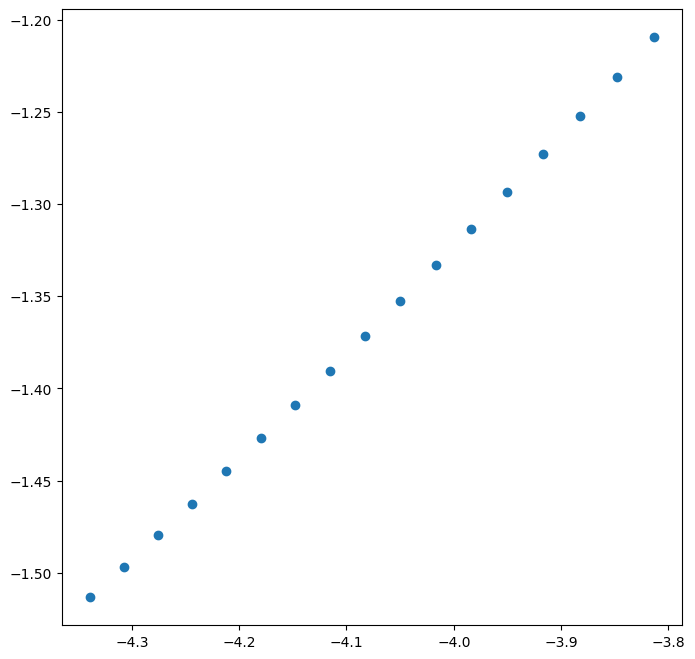

In [ ]:
## for checking
for batch in train_dl:
  x, y = batch
  # print(x)
  # print(y)
  # x = x.to(device)
  # y = y.to(device)
  print(x.shape, y.shape)
  print(x.dtype, y.dtype)
  ## sanity check
  plt.plot(x[0], y[0], 'o')
  break

## Define NN

In [ ]:
## take previous prev_k samples and create observavle first

class Encoder(nn.Module):
  def __init__(self, input_dim=hyper_param['input_dim'], latent_dim=hyper_param['latent_dim']):
    super(Encoder, self).__init__()
    self.l1 = nn.Linear(input_dim, 100)
    self.l2 = nn.Linear(100, 200)
    self.l3 = nn.Linear(200, latent_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.l1(x))
    x = self.relu(self.l2(x))
    x = self.l3(x)
    return x


class Decoder(nn.Module):
  def __init__(self, output_dim=hyper_param['input_dim'], latent_dim=hyper_param['latent_dim']):
    super(Decoder, self).__init__()
    self.l1 = nn.Linear(latent_dim, 200)
    self.l2 = nn.Linear(200, 100)
    self.l3 = nn.Linear(100, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.l1(x))
    x = self.relu(self.l2(x))
    x = self.l3(x)
    return x

class Koopman(nn.Module):
  def __init__(self, latent_dim = hyper_param['latent_dim']):
    super(Koopman, self).__init__()
    self.K = nn.Linear(latent_dim, latent_dim)

  def forward(self, x):
    return self.K(x)


class AutoEncoder(nn.Module):
  def __init__(self, input_dim=hyper_param['input_dim'], latent_dim=hyper_param['latent_dim']):
    super(AutoEncoder, self).__init__()
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.encoder = Encoder(input_dim=hyper_param['input_dim'], latent_dim=hyper_param['latent_dim'])
    self.koopman = Koopman(latent_dim = hyper_param['latent_dim'])
    self.decoder = Decoder(output_dim=hyper_param['input_dim'], latent_dim=hyper_param['latent_dim'])

  def forward(self, x):
    ##
    encoded = self.encoder(x)
    incremented = self.koopman(encoded)
    decoded_next = self.decoder(incremented)
    decoded_curr = self.decoder(encoded)
    return encoded, incremented, decoded_next, decoded_curr

model = AutoEncoder()

In [ ]:
model

AutoEncoder(
  (encoder): Encoder(
    (l1): Linear(in_features=32, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=200, bias=True)
    (l3): Linear(in_features=200, out_features=128, bias=True)
    (relu): ReLU()
  )
  (koopman): Koopman(
    (K): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=128, out_features=200, bias=True)
    (l2): Linear(in_features=200, out_features=100, bias=True)
    (l3): Linear(in_features=100, out_features=32, bias=True)
    (relu): ReLU()
  )
)

## Training

### Define Losses

In [ ]:
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay, nesterov=False)
optimizer = torch.optim.Adam(model.parameters(), lr = hyper_param['learning_rate'])

### Train Loop

In [ ]:
from tqdm.notebook import tqdm
import pickle

In [ ]:
logs = {'epoch':[], 'train_loss':[], 'loss1':[], 'loss2':[], 'loss3':[]}

In [ ]:
def unroll(x, y):
  '''
  prams: x-> (BS,n) list of x coors
         y-> (BS,n) list of y coors
  return (BS, 2*n) x and y coors concatenated
  '''
  return torch.cat((x,y),1)


In [ ]:
FOLDER = '/content/drive/MyDrive/NOTEBOOK/training_dump/koopman3/'

In [ ]:
model = model.to(device)
model.train()
for epoch in range(hyper_param['n_epoch']):
  loss_per_epoch = 0
  loss1_per_epoch = loss2_per_epoch = loss3_per_epoch = 0
  for batch in (pbar := tqdm(train_dl)):
    x, y = batch
    ## concatenate x and y
    # print(x)
    # print(y)
    input_feats = unroll(x[:,:-1], y[:,:-1]).to(device)
    output_feats = unroll(x[:,1:], y[:,1:]).to(device)

    BS = input_feats.shape[0]
    model_inp = torch.cat((input_feats, output_feats), 0).to(device)

    encoded, incremented, decoded_next, decoded_curr = model(model_inp)

    loss1 = criterion(decoded_curr[:BS], input_feats) ## MSE on input_feats and decoded_curr --- RECONSTRUCTION
    loss2 = criterion(decoded_next[:BS], output_feats) ## MSE on output_feats and decoded_curr  --- STATE PREDICTION
    loss3 = criterion(incremented[:BS], encoded[BS:]) ## Koopman observable loss
    loss = loss1 + loss2 + loss3
    # print(loss)
    # break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_per_epoch += loss.detach().item()
    loss1_per_epoch += loss1.detach().item()
    loss2_per_epoch += loss2.detach().item()
    loss3_per_epoch += loss3.detach().item()
  # break
    pbar.set_description(f'epoch: {epoch}, loss: {loss.detach().item()}')
  logs['epoch'].append(epoch)
  logs['train_loss'].append(loss_per_epoch/len(train_dl))
  logs['loss1'].append(loss1_per_epoch/len(train_dl))
  logs['loss2'].append(loss2_per_epoch/len(train_dl))
  logs['loss3'].append(loss3_per_epoch/len(train_dl))
  ## dump every 5th epoch
  if epoch%5 == 0:
    ## save logs
    with open(FOLDER + 'train_logs.pkl', 'wb') as f:
      pickle.dump(logs, f)
    ## save model
    torch.save(model.state_dict(), FOLDER + 'koopman_model.pth')

  # break



  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

## View Losses

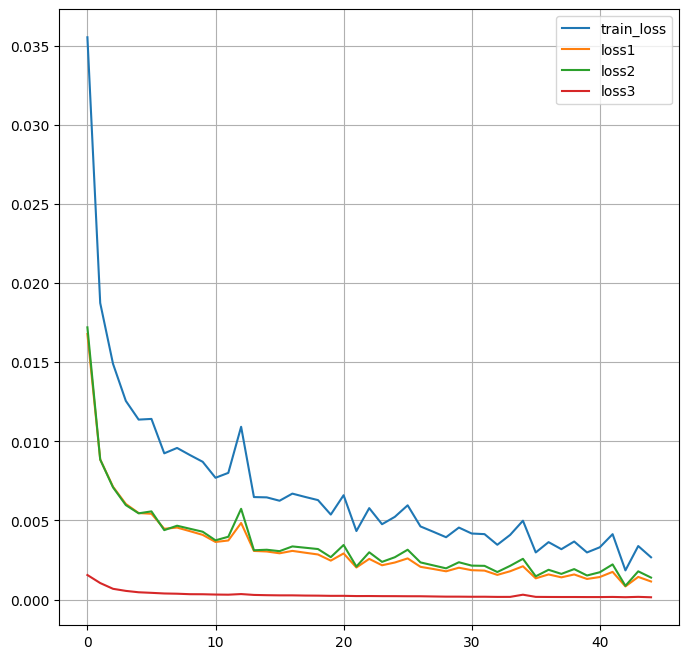

In [ ]:
for key in logs:
  if key not in  ['epoch', 'loss4']:
    plt.plot(log_info[key][1:-100], label=key)
plt.legend()
plt.grid()
plt.show()

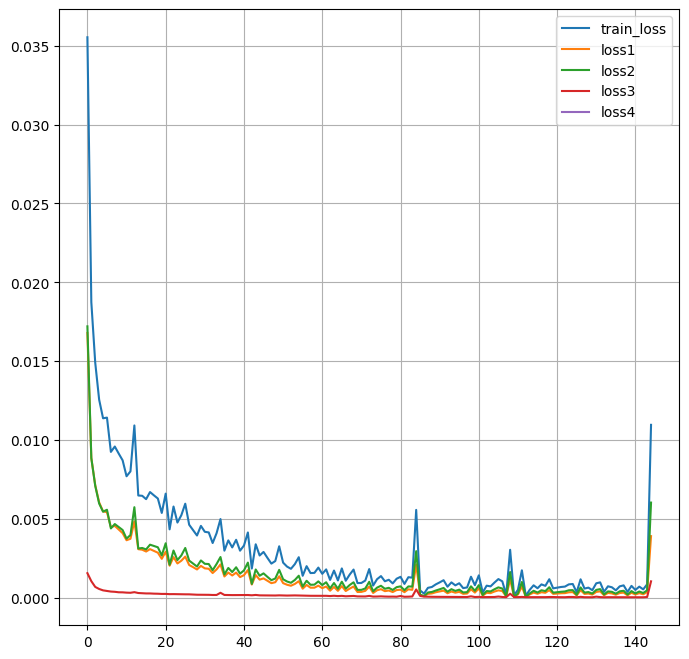

In [ ]:
with open(FOLDER + 'train_logs.pkl', 'rb') as f:
  log_info = pickle.load(f)

for key in log_info:
  if key != 'epoch':
    plt.plot(log_info[key][1:-1], label=key)
plt.legend()
plt.grid()
plt.show()

## Inference

In [ ]:
def infer(starting_points, time_step = 20):
  '''
  params: list of starting points [(x0, y0)]
  return: list of trajectories of size time_step for each starting point
  '''
  k = hyper_param['prev_k']
  n = len(starting_points)
  res = [[(float(x0), float(y0))] for x0, y0 in starting_points]

  model_inp =  [[0]*(k-1) + [x0] + [0]*(k-1) + [y0] for x0, y0 in starting_points]## BS = n, prev_k = 10
  model_inp = torch.tensor(model_inp).to(device)
  with torch.no_grad():
    encoded, incremented, decoded_next, decoded_curr  = model(model_inp)
  ## iteratively decode next point based on info of prev 10
  for _ in range(time_step):
    decoded_next = model.decoder(incremented)
    ## add it to data point
    for i in range(n):
      x_ = decoded_next[i][k-1]
      y_ = decoded_next[i][2*k-1]
      res[i].append((float(x_) , float(y_)))
    # for next iter
    incremented = model.koopman(incremented)

  return res

In [ ]:
### randomly take starting points
sps = [(np.random.rand()*4-2 , np.random.rand()*4-2) for _ in range(500)]
paths_inferred = infer(sps, 100)

In [ ]:
paths_actual = [generate_path(x0, y0, steps=100) for x0,y0 in sps]

In [ ]:
def compare_paths(paths1, paths2):
  for path1, path2 in zip(paths1, paths2):
    x1 , y1 = zip(*path1)
    plt.plot(x1, y1, '-', label='actual trajectory')

    x2 , y2 = zip(*path2)
    plt.plot(x2, y2, '--', label='infererd from model')


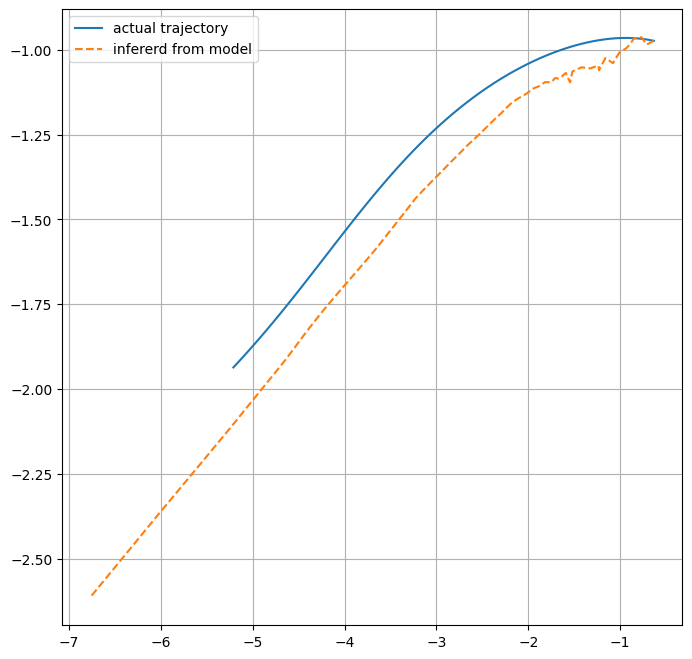

In [ ]:
a = np.random.randint(100)
# compare_paths(paths_actual[a:a+1], paths_inferred[a:a+1])
compare_paths(paths_actual[:], paths_inferred[:])
plt.grid()
plt.legend()
plt.show()

In [ ]:
def flow_f(paths1):
  for path1 in paths1:
    x1 , y1 = [], []
    for x,y in path1:
      x1.append(x)
      y1.append(y)
    plt.plot(x1, y1, '-')

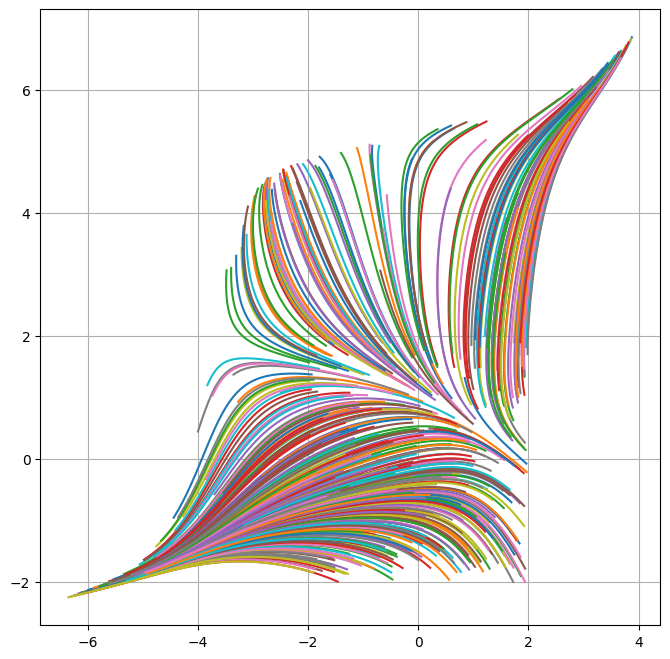

In [ ]:
flow_f(paths_actual)
plt.grid()
# plt.legend()
plt.show()

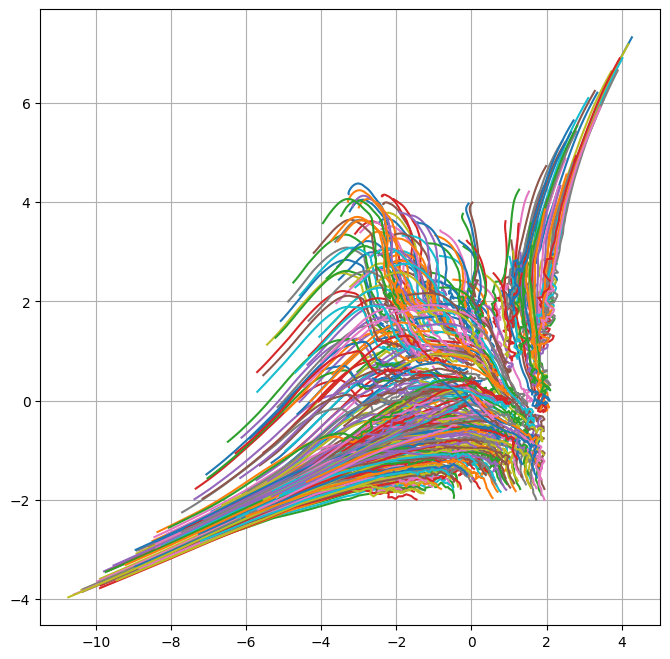

In [ ]:
flow_f(paths_inferred)
plt.grid()
# plt.legend()
plt.show()

## Thank You :)